In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML Models
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer

**Import Data**

In [39]:
# Linked Birth Infant Death Records 2017-2018
birth_deaths = pd.read_fwf("./data/birth.txt")

# Physicians and Surgeons by race/ethnicity and practice
physicians = pd.read_csv("./data/physicians.csv")

# Raw Birth Data -> https://data.nber.org/linkpe/2013/LinkPE13Guide.pdf
birth_deaths_raw = pd.read_csv("./data/US_Birth_Data_Short.csv")

births_deaths_large = pd.read_csv("./data/US_Birth_Data_2013.csv")

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (326,329,332,335,338,366,367,368,369,370) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [40]:
print("birth_deaths:", len(birth_deaths), "physicians:", len(physicians), "raw:", len(birth_deaths_raw))

birth_deaths: 77 physicians: 892 raw: 1000


In [41]:
physicians.head(10)

,Month,Year,Primary Practice County,Race/Ethnicity,Count of Licensees
0,March,2016,Alameda,African-American/Black/African,148
1,March,2016,Alameda,American Indian/ Native America,6
2,March,2016,Alameda,Asian - Cambodian,1
3,March,2016,Alameda,Asian - Chinese,284
4,March,2016,Alameda,Asian - Indian,273
5,March,2016,Alameda,Asian - Indonesian,2
6,March,2016,Alameda,Asian - Japanese,20
7,March,2016,Alameda,Asian - Korean,41
8,March,2016,Alameda,Asian - Other Asian,34
9,March,2016,Alameda,Asian - Pakistani,15


<AxesSubplot:xlabel='Race/Ethnicity', ylabel='Count of Licensees'>

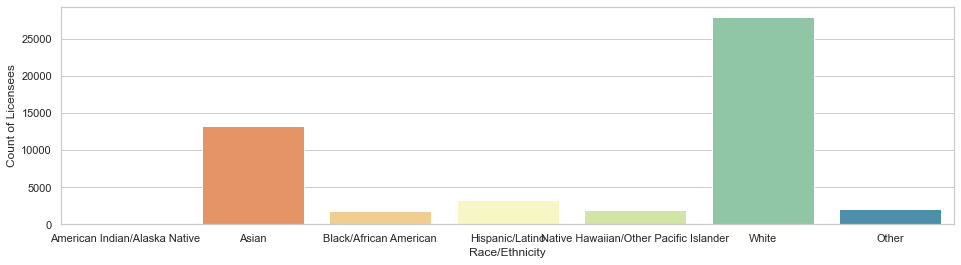

In [42]:
# Simplify Race/Ethnicity into ethnic groups (https://grants.nih.gov/grants/guide/notice-files/not-od-15-089.html)
ethnic_groups = {
    "American Indian/Alaska Native": 0,
    "Asian": 0,
    "Black/African American": 0,
    "Hispanic/Latino": 0,
    "Native Hawaiian/Other Pacific Islander": 0,
    "White": 0,
    "Other": 0
}

for index, row in physicians.iterrows():
    if 'White' in row['Race/Ethnicity']:
        ethnic_groups['White'] += row['Count of Licensees']
    elif 'Latino' in row['Race/Ethnicity'] or 'Hispanic' in row['Race/Ethnicity']:
        ethnic_groups['Hispanic/Latino'] += row['Count of Licensees']
    elif 'African-American' in row['Race/Ethnicity'] or 'Black' in row['Race/Ethnicity']:
        ethnic_groups['Black/African American'] += row['Count of Licensees']
    elif 'Hawaiian' in row['Race/Ethnicity']:
        ethnic_groups['Native Hawaiian/Other Pacific Islander'] += row['Count of Licensees']
    elif 'Asian' in row['Race/Ethnicity'] or 'Taiwanese' in row['Race/Ethnicity'] or 'Singaporean' in row['Race/Ethnicity'] or 'Malaysian' in row['Race/Ethnicity']:
        ethnic_groups['Asian'] += row['Count of Licensees']
    elif 'Native America' in row['Race/Ethnicity']:
        ethnic_groups['American Indian/Alaska Native'] += row['Count of Licensees']
    else:
        ethnic_groups['Other'] += row['Count of Licensees']
    
columns = ['Race/Ethnicity', 'Count of Licensees']

data = []
for race, count in ethnic_groups.items():
    data.append([race, count])

physicians_ethnic_groups = pd.DataFrame(data, columns=columns)

# Plot!
sns.set(style="whitegrid")

plt.figure(1, figsize=(16,4))
sns.barplot(x='Race/Ethnicity',y='Count of Licensees', data=physicians_ethnic_groups, palette='Spectral')

In [43]:
# Obviously a lot of data so let's cleanup
birth_deaths_raw.columns

Index(['laterec', 'DOB_YEAR', 'DOB_MONTH', 'DOB_TIME', 'DOB_DAY_OF_WEEK',
       'OCCURENCE_TERRITORY', 'OCCURENCE_FIPS_COUNTY',
       'OCCURENCE_COUNTY_POPULATION', 'BIRTH_PLACE_REVISED', 'BIRTH_PLACE',
       ...
       'stoccfipd', 'cntoccfipd', 'stresfipd', 'drcnty', 'cntyrfpd',
       'cntrsppd', 'hospd', 'weekdayd', 'dthyr', 'dthmon'],
      dtype='object', length=388)

In [44]:
race_df = births_deaths_large[births_deaths_large["MOTHERS_RACE"].notnull()]

print(race_df.head(5))

  revision  laterec  DOB_YEAR  DOB_MONTH  DOB_TIME  DOB_DAY_OF_WEEK  \
0        S        0      2012          5       NaN                3   
1        S        0      2012          5       NaN                5   
2        S        0      2012          6       NaN                2   
3        S        0      2012          9       NaN                7   
4        S        0      2012          9       NaN                3   

   OCCURENCE_TERRITORY  OCCURENCE_FIPS_COUNTY  OCCURENCE_COUNTY_POPULATION  \
0                  NaN                    NaN                          NaN   
1                  NaN                    NaN                          NaN   
2                  NaN                    NaN                          NaN   
3                  NaN                    NaN                          NaN   
4                  NaN                    NaN                          NaN   

   BIRTH_PLACE_REVISED  ...  stoccfipd  cntoccfipd  stresfipd  drcnty  \
0                  NaN  ...    

Text(0.5, 1.0, 'Race of Mother')

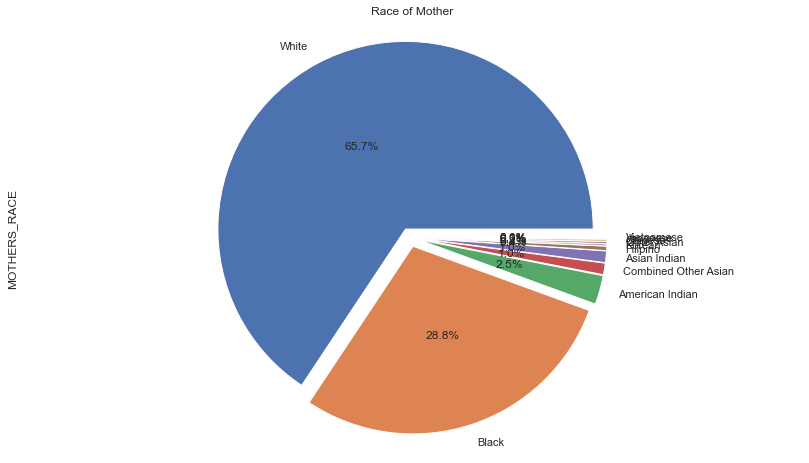

In [45]:
pie, ax = plt.subplots(figsize=[14,8])
labels = 'White', 'Black', 'American Indian', 'Combined Other Asian', 'Asian Indian', 'Filipino', 'Korean', 'Other Asian', 'Chinese', 'Japanese', 'Vietnamese'
race_df["MOTHERS_RACE"].value_counts().plot(kind='pie', labels=labels, explode=[0.05]*11, autopct="%.1f%%", pctdistance=0.5)
plt.axis('equal')
plt.title('Race of Mother')

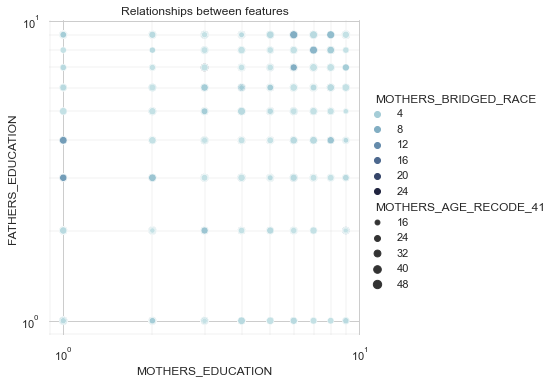

In [46]:
copy_large = births_deaths_large.copy()
cleaned_df = copy_large[copy_large[['MOTHERS_BRIDGED_RACE', 'MOTHERS_EDUCATION', 'FATHERS_EDUCATION', 'MOTHERS_AGE_RECODE_41']].notnull().all(1)]
cleaned_columns_df = cleaned_df[['MOTHERS_BRIDGED_RACE', 'MOTHERS_EDUCATION', 'FATHERS_EDUCATION', 'MOTHERS_AGE_RECODE_41']]

sns.set_theme(style="whitegrid")

cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
g = sns.relplot(
    data=cleaned_columns_df,
    x="MOTHERS_EDUCATION", y="FATHERS_EDUCATION",
    hue="MOTHERS_BRIDGED_RACE", size="MOTHERS_AGE_RECODE_41",
    palette=cmap
)
g.set(xscale="log", yscale="log")
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
g.ax.set_title('Relationships between features')
g.despine(left=True, bottom=True)

In [47]:
scalar = StandardScaler()

birth_deaths_raw_int_columns = birth_deaths_raw.copy().select_dtypes(include=['int64'])

for col in birth_deaths_raw_int_columns.columns:
    birth_deaths_raw_int_columns = birth_deaths_raw_int_columns[birth_deaths_raw_int_columns[col].apply(lambda x: type(x) != str)]

rawY = birth_deaths_raw_int_columns.iloc[0:, 0].values
rawX = birth_deaths_raw_int_columns.iloc[0:, 1:].values

scalar.fit(rawX)
rawX = scalar.transform(rawX)

for i in range(len(birth_deaths_raw_int_columns[1:])):
    print(birth_deaths_raw_int_columns.columns[i+1] + ' Scalar Mean:', scalar.mean_[i], 'Scalar Scale:', scalar.scale_[i])

DOB_YEAR Scalar Mean: 2012.0 Scalar Scale: 1.0
DOB_MONTH Scalar Mean: 9.619 Scalar Scale: 2.34047836990646
DOB_DAY_OF_WEEK Scalar Mean: 4.022 Scalar Scale: 1.8972390466148432
BIRTH_PLACE Scalar Mean: 1.023 Scalar Scale: 0.2654637451705977
BIRTH_PLACE_RECODE Scalar Mean: 1.008 Scalar Scale: 0.08908422980528033
MOTHERS_AGE_RECODE_41 Scalar Mean: 26.571 Scalar Scale: 6.266335372448557
MOTHERS_AGE_RECODE_14 Scalar Mean: 8.802 Scalar Scale: 1.5623047077955055
MOTHERS_AGE_RECODE_9 Scalar Mean: 3.928 Scalar Scale: 1.2933738825258536
RESIDENCE_STATUS Scalar Mean: 1.294 Scalar Scale: 0.5075076354105423
MOTHERS_RACE_RECODE Scalar Mean: 1.492 Scalar Scale: 0.8135944935900192
MOTHERS_HISPANIC_ORIGIN Scalar Mean: 0.546 Scalar Scale: 1.4134652454163843
MOTHERS_RACE_HISPANIC_ORIGIN Scalar Mean: 5.541 Scalar Scale: 2.1312716861066776
MOTHERS_MARITAL_STATUS Scalar Mean: 1.602 Scalar Scale: 0.48948544411453143
FATHERS_AGE_RECODE_11 Scalar Mean: 6.165 Scalar Scale: 3.0701425048358915
FATHERS_RACE_RECODE 

IndexError: index 167 is out of bounds for axis 0 with size 167

In [ ]:
means, scales = scalar.mean_, scalar.scale_

means_top = np.argsort(means)[::-1]
scales_top = np.argsort(scales)[::-1]

print('Most important features (mean) are: ', end = '')

for i in means_top[:5]:
    print(birth_deaths_raw_int_columns.columns[i], end = ', ')
    
print('\n')

print('Most important features (scale) are: ', end = '')

for i in scales_top[:5]:
    print(birth_deaths_raw_int_columns.columns[i], end = ', ')

In [ ]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import math

def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(rawX), rawY), rmse(m.predict(validX), validY),
                m.score(rawX, rawY), m.score(validX, validY)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

copy_1 = birth_deaths_raw.copy()
copy_1 = copy_1.select_dtypes(include=['float64', 'int64'])
copy_1 = copy_1.fillna(0)

copy_2 = copy_1.copy()
copy_2 = copy_2[:1000]

forest_regressor = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)

rawX, rawY = copy_2.iloc[0:, 1:].values, copy_2.iloc[0:, 0].values
validX, validY = copy_1.iloc[0:, 1:].values, copy_1.iloc[0:, 0].values

forest_regressor.fit(rawX, rawY)

print_score(forest_regressor)

In [ ]:
df_logistic = births_deaths_large.copy()
df_logistic = df_logistic.select_dtypes(include=['float64', 'int64'])
df_logistic = df_logistic.fillna(0)

df_logistic = df_logistic[df_logistic[['aged']].notnull().all(1)]

Y_train = df_logistic.iloc[:292, 220].values
text_train = df_logistic.loc[:1000, df_logistic.columns != 'aged']

vec = CountVectorizer()
X_train = vec.fit_transform(text_train)
feature_names = np.asarray(vec.get_feature_names())

Y_test = df_logistic.iloc[292:584, 220].values
text_test = df_logistic.iloc[1000:, df_logistic.columns != 'aged']
X_test = vec.transform(text_test)

alpha_train, alpha_test, training_accuracy, test_accuracy = [], [], [], []
alpha_vals = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

for alphas in alpha_vals:    
    # Classify data
    alpha_train.append(SGDClassifier(loss='log', max_iter=1000, tol=1.0e-12, random_state=123, average=False, alpha=alphas))
    alpha_test.append(SGDClassifier(loss='log', max_iter=1000, tol=1.0e-12, random_state=123, average=False, alpha=alphas))
    
    # Fit data
    alpha_train[len(alpha_train) - 1].fit(X_train, Y_train)
    alpha_test[len(alpha_test) - 1].fit(X_test, Y_test)

# Get the training and testing accuracy based on different alpha values
for alphas in range(0, 7):
    training_accuracy.append(accuracy_score(Y_train, alpha_train[alphas].predict(X_train)))
    test_accuracy.append(accuracy_score(Y_test, alpha_test[alphas].predict(X_test)))

# Plot the data
fig = plt.figure()
plt.figure(figsize=(16,5))
plt.semilogx(alpha_vals, training_accuracy, label="Training Data")
plt.semilogx(alpha_vals, test_accuracy, label="Testing Data")
plt.grid(True)
fig.suptitle('Accuracy vs. Alpha', fontsize=18)
plt.xlabel('Alpha', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend()
plt.show()

In [ ]:
classifier = SGDClassifier(loss='perceptron', max_iter=1000, tol=1.0e-12, random_state=123, average=True)
classifier.fit(X_train, Y_train)

print("Number of SGD iterations: %d" % classifier.n_iter_)
print("Training accuracy: %0.6f" % accuracy_score(Y_train, classifier.predict(X_train)))
print("Testing accuracy: %0.6f" % accuracy_score(Y_test, classifier.predict(X_test)))

args, feature_weights = np.argsort(classifier.coef_[0]), []

for a in args:
    feature_weights.append([feature_names[a], classifier.coef_[0][a]])
    
print()
print("Top three features that hurt baby's lifespan:")
print("\"%s\": %0.8f" % (feature_weights[:3][0][0], feature_weights[:3][0][1]))
print("\"%s\": %0.8f" % (feature_weights[:3][1][0], feature_weights[:3][1][1]))
print("\"%s\": %0.8f" % (feature_weights[:3][2][0], feature_weights[:3][2][1]))

print()
print("Top three features that increased baby's lifespan:")
print("\"%s\": %0.8f" % (feature_weights[-3:][0][0], feature_weights[-3:][0][1]))
print("\"%s\": %0.8f" % (feature_weights[-3:][1][0], feature_weights[-3:][1][1]))
print("\"%s\": %0.8f" % (feature_weights[-3:][2][0], feature_weights[-3:][2][1]))

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score

df_logistic = births_deaths_large.copy()
df_logistic = df_logistic.select_dtypes(include=['float64', 'int64'])
df_logistic = df_logistic.fillna(0)

df_logistic = df_logistic[df_logistic[['LIVE_BIRTH_ORDER_RECODE']].notnull().all(1)]

Y_train = df_logistic.iloc[:292, 42].values
text_train = df_logistic.loc[:1000, df_logistic.columns != 'LIVE_BIRTH_ORDER_RECODE']

vec = CountVectorizer()
X_train = vec.fit_transform(text_train)
feature_names = np.asarray(vec.get_feature_names())

Y_test = df_logistic.iloc[292:584, 42].values
text_test = df_logistic.iloc[1000:, df_logistic.columns != 'LIVE_BIRTH_ORDER_RECODE']
X_test = vec.transform(text_test)

alpha_train, alpha_test, training_accuracy, test_accuracy = [], [], [], []
alpha_vals = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

for alphas in alpha_vals:    
    # Classify data
    alpha_train.append(SGDClassifier(loss='log', max_iter=1000, tol=1.0e-12, random_state=123, average=False, alpha=alphas))
    alpha_test.append(SGDClassifier(loss='log', max_iter=1000, tol=1.0e-12, random_state=123, average=False, alpha=alphas))
    
    # Fit data
    alpha_train[len(alpha_train) - 1].fit(X_train, Y_train)
    alpha_test[len(alpha_test) - 1].fit(X_test, Y_test)

# Get the training and testing accuracy based on different alpha values
for alphas in range(0, 7):
    training_accuracy.append(accuracy_score(Y_train, alpha_train[alphas].predict(X_train)))
    test_accuracy.append(accuracy_score(Y_test, alpha_test[alphas].predict(X_test)))

# Plot the data
fig = plt.figure()
plt.figure(figsize=(16,5))
plt.semilogx(alpha_vals, training_accuracy, label="Training Data")
plt.semilogx(alpha_vals, test_accuracy, label="Testing Data")
plt.grid(True)
fig.suptitle('Accuracy vs. Alpha', fontsize=18)
plt.xlabel('Alpha', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend()
plt.show()

In [ ]:
classifier = SGDClassifier(loss='perceptron', max_iter=1000, tol=1.0e-12, random_state=123, average=True)
classifier.fit(X_train, Y_train)

print("Number of SGD iterations: %d" % classifier.n_iter_)
print("Training accuracy: %0.6f" % accuracy_score(Y_train, classifier.predict(X_train)))
print("Testing accuracy: %0.6f" % accuracy_score(Y_test, classifier.predict(X_test)))

args, feature_weights = np.argsort(classifier.coef_[0]), []

for a in args:
    feature_weights.append([feature_names[a], classifier.coef_[0][a]])
    
print()
print("Top three features that hurt live birth recode")
print("\"%s\": %0.8f" % (feature_weights[:3][0][0], feature_weights[:3][0][1]))
print("\"%s\": %0.8f" % (feature_weights[:3][1][0], feature_weights[:3][1][1]))
print("\"%s\": %0.8f" % (feature_weights[:3][2][0], feature_weights[:3][2][1]))

print()
print("Top three features that increased live birth recode")
print("\"%s\": %0.8f" % (feature_weights[-3:][0][0], feature_weights[-3:][0][1]))
print("\"%s\": %0.8f" % (feature_weights[-3:][1][0], feature_weights[-3:][1][1]))
print("\"%s\": %0.8f" % (feature_weights[-3:][2][0], feature_weights[-3:][2][1]))

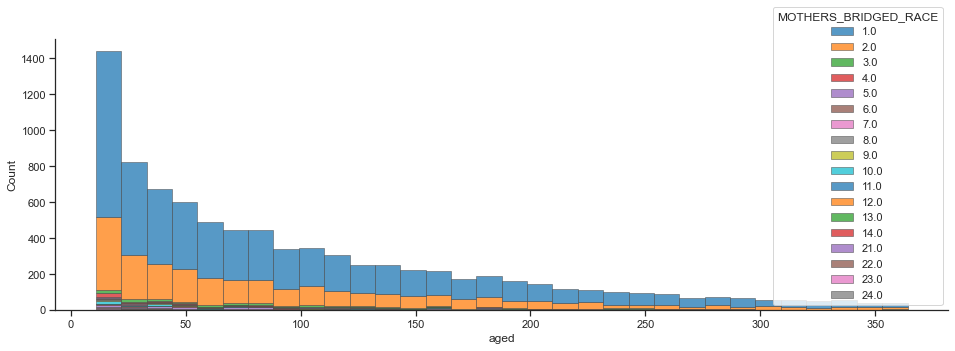

In [68]:
import matplotlib.ticker as mpl

copy_large_2 = births_deaths_large.copy()
cleaned_df_2 = copy_large_2[copy_large_2[['MOTHERS_BRIDGED_RACE', 'aged']].notnull().all(1)]
cleaned_columns_df_2 = cleaned_df_2[['MOTHERS_BRIDGED_RACE', 'aged']]
df_filtered = cleaned_columns_df_2[cleaned_columns_df_2['aged'] > 10]

sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(16, 5))
sns.despine(f)

sns.histplot(
    df_filtered,
    x="aged", hue="MOTHERS_BRIDGED_RACE",
    multiple="stack",
    palette="tab10",
    edgecolor=".3",
    linewidth=.5
)
ax.xaxis.set_major_formatter(mpl.ScalarFormatter())

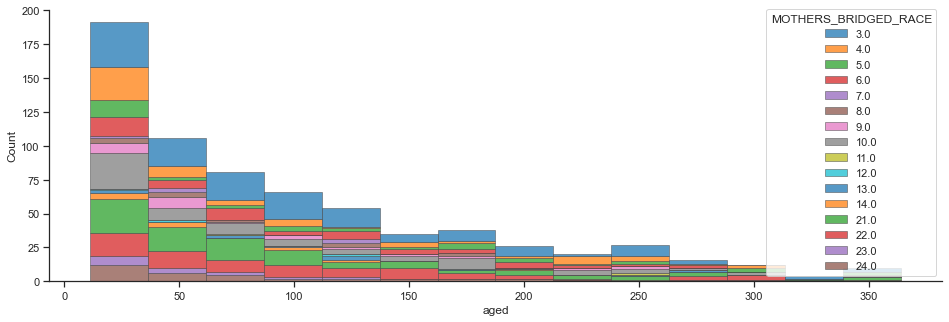

In [71]:
import matplotlib.ticker as mpl

filtered_df = df_filtered[df_filtered['MOTHERS_BRIDGED_RACE'] != 1.0]
filtered_df_1 = filtered_df[filtered_df['MOTHERS_BRIDGED_RACE'] != 2.0]

sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(16, 5))
sns.despine(f)

sns.histplot(
    filtered_df_1,
    x="aged", hue="MOTHERS_BRIDGED_RACE",
    multiple="stack",
    palette="tab10",
    edgecolor=".3",
    linewidth=.5
)
ax.xaxis.set_major_formatter(mpl.ScalarFormatter())